## 统计套利：利用相关系数进行配对交易 <br>

**导语**：本篇内容你将会学会如何运用相关系数找出适合套利的股票标的，并编写套利策略，进行套利交易。

#### 什么是配对交易？

　　配对交易是指八十年代中期华尔街著名投行Morgan Stanley的数量交易员Nunzio Tartaglia成立的一个数量分析团队提出的一种市场中性投资策略。
　　Ganapathy Vidyamurthy在《Pairs Trading: Quantitative Methods and Analysis》一书中定义配对交易为两种类型：一类是基于统计套利的配对交易，一类是基于风险套利的配对交易。
  
　　基于统计套利的配对交易策略是一种市场中性策略，具体的说，是指从市场上找出历史股价走势相近的股票进行配对，当配对的股票价格差（Spreads）偏离历史均值时，则做空股价较高的股票同时买进股价较低的股票，等待他们回归到长期均衡关系，由此赚取两股票价格收敛的报酬。
  
#### 配对交易原理

　　配对交易策略的基本原理是基于两个相关性较高的股票或者其他证券，如果在未来时期保持着良好的相关性，一旦两者之间出现了背离的走势，且这种背离在未来是会得到纠正的，那么就可能产生套利的机会。对于配对交易的实践而言，如果两个相关性较高的股票或者其他证券之间出现背离，就应该买进表现相对较差的，卖出表现相对较好的。当未来两者之间的背离得到纠正，那么可以进行相反的平仓操作来获取利润。
    
　　由于配对交易利用配对间的短期错误定价，通过持有相对低估，卖空相对高估，因此其本质上是一个反转投资策略，其核心是学术文献中的股票价格均值回复。尽管配对交易策略非常简单，但却被广泛应用，其之所以能被广泛应用的主要原因是:首先，配对交易的收益与市场相独立，即市场中性，也就是说它与市场的上涨或者下跌无关;其次，其收益的波动性相对较小;第三，其收益相对稳定。
  
#### 统计套利：利用相关系数进行配对交易 

　　1.首先想到利用统计套利，可能会想到两只股票的相关系数是否会让两只股票的走势有一种特定关系。

In [1]:
#导入相应的python库包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

　　首先相关系数的公式定义为下，将协方差标准化即得到我们需要的相关系数
  ![](http://u.thsi.cn/fileupload/data/Sns/2018/d12f8eb9341d5e1cc7b865550c3cb994.png)
  
　　我们来看看相关系数高的数据集具体长什么样

相关系数：0.963266983769


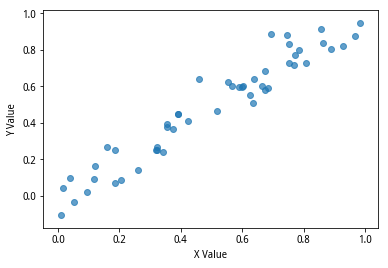

In [2]:
X = np.random.rand(50)
Y = X + np.random.normal(0, 0.1, 50)

plt.scatter(X,Y,alpha=0.7)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print ('相关系数：' + str(np.corrcoef(X, Y)[0, 1]))

　　从图像上看，数据基本都落在一条直线上那么它们之间的相关性就会很高。 接下来我们来看看两只股票价格之间相关性高长什么样，我们以中国航空和南方航空为例。

601111.SH与600029.SH之间的相关系数:  0.952849080194


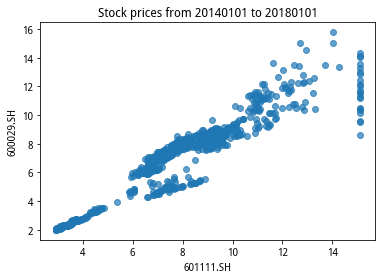

In [3]:
start = '20140101'#此处时间一定要与回测的时间相对应，因为不同时间可能相关性不一致
end = '20180101'
stock1='601111.SH'
stock2='600029.SH'
a1 = get_price(stock1, start, end, '1d', ['close'], False)['close']
a2 = get_price(stock2, start, end, '1d', ['close'], False)['close']
#上图
plt.scatter(a1,a2,alpha=0.7)
plt.xlabel(stock1)
plt.ylabel(stock2)
plt.title('Stock prices from ' + start + ' to ' + end)
print (stock1+"与"+stock2+"之间的相关系数: ", np.corrcoef(a1,a2)[0,1])

    同样数据大多都集中在一条直线上

    找到相关性高的股票对，我们要来研究它们之间的价差，因为这是我们策略套利的关键

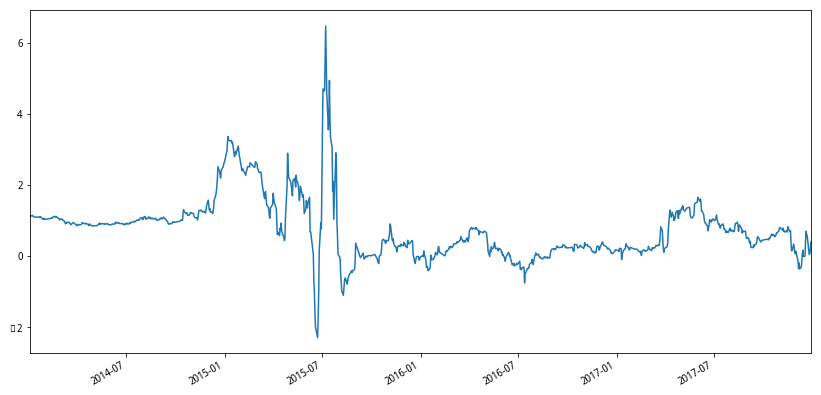

In [5]:
a3=a1-a2
a3.plot(figsize=(14,7))

    从图中看出，两只股票的相关系数高，两者之间的价差大致围绕一个常数波动，那么其价差是否平稳，我们通过ADF单位根检验，来判断一下序列是否平稳。


In [7]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(a3)#使用adf单位根检验平稳性
result = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
        result['Critical Value (%s)'%key] = value
print(result)

Test Statistic                  -3.049276
p-value                          0.030542
Lags Used                       22.000000
Number of Observations Used    954.000000
Critical Value (10%)            -2.568386
Critical Value (5%)             -2.864574
Critical Value (1%)             -3.437223
dtype: float64


    根据ADF单位根检验结果，此处检验出来价差平稳，价差基础对套利策略的实施有利。 
    ADF单位根检验结果判断技巧：
        A.看p-value值，一般小于0.05即为平稳
        B.看Test statistic值，一般小于Critical Value (5%)的值即为平稳

    进一步的我们来看看价差均值基础上加减一个价差标准差作为套利上下轨，上下轨区间是否包含了大部分的差价区间？

    
    可以看到上下轨区间包含了大部分价差区间，但是在牛市中，两者价差波动非常大，不利于套利策略实施，但是在牛市后，两者的价差稳定在上下轨之间波动，非常适合进行套利策略。

    让我们计算两者60日滚动相关性，来看看两者变化趋势。

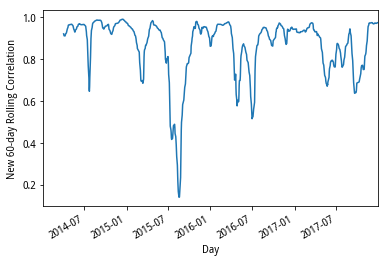

In [8]:
rolling_correlation_cn = pd.rolling_corr(a1, a2, 60)
rolling_correlation_cn.plot()
plt.xlabel('Day')
plt.ylabel('New 60-day Rolling Correlation')

　　从相关系数的60日滚动相关性来看其实这两只股票相关性是非常高的，除了牛市中相关性降低一段时间外，其余时间都保持在0.7以上。

　　通过简单的套利策略，针对中国国航和南方航空，我们展开套利回测，回测结果如下：
    ![](http://u.thsi.cn/fileupload/data/Sns/2018/45be3d31b5ffe8feecfe30e9e55cf48b.png)

套利策略代码如下：

In [ ]:
import numpy as np

def initialize(account):
    #选取研究后相关系数较高的股票对
    g.s1 = '601111.SH'
    g.s2 = '600029.SH'
    
def handle_data(account,data):
    # 取得选取的两只股票1年的收盘价并算出差价
    price_stock1=history(g.s1,['close'],250,'1d',True)['close'].values
    price_stock2=history(g.s2,['close'],250,'1d',True)['close'].values
    diff=price_stock1-price_stock2
    #以均值加一倍标准差作为上开仓线
    up=np.mean(diff)+np.std(diff)
    #以均值减一倍标准差作为下开仓线
    down=np.mean(diff)-np.std(diff)
    #取得进行交易前一天股票的收盘价并计算差价
    yesterday_price1=history(g.s1,['close'],1,'1d',True)['close'][0]
    yesterday_price2=history(g.s2,['close'],1,'1d',True)['close'][0]
    yesterday_diff=yesterday_price1-yesterday_price2
    #前一天差价达到上开仓线即卖出股票s1，做多s2
    if yesterday_diff>up:
        order_target_percent(g.s1,0)
        order_target_percent(g.s2,1)
    #前一天的差价达到下开仓线即卖出股票s2，做多s1
    if yesterday_diff<down:
        order_target_percent(g.s2,0)
        order_target_percent(g.s1,1)